In [86]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

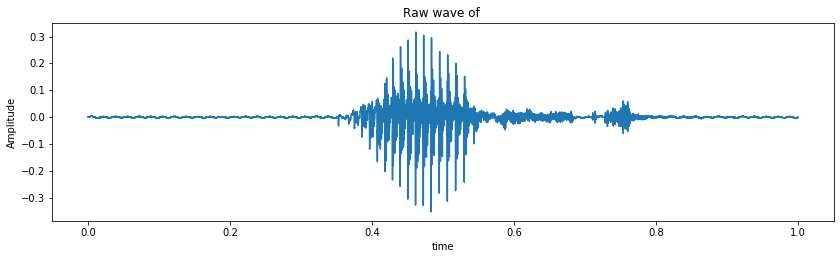

In [88]:
train_audio_path = 'C:/Users/rafoo/Desktop/Alexa/data/tensorflow-speech-recognition-challenge/train_small/'
samples, sample_rate = librosa.load(train_audio_path+'left/0d393936_nohash_1.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

Sampling: The sampling rate or sampling frequency is defined as the number of samples selected per second

In [ ]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

Resampling from 16000Hz to 8000Hz:

In [90]:
#samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

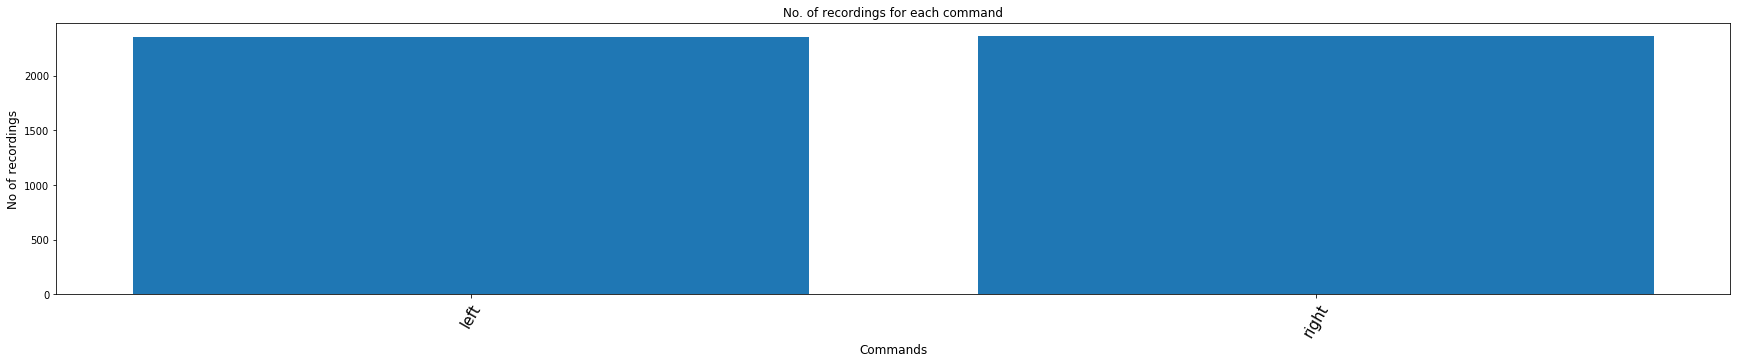

In [91]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

#labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

Duration of recordings: A look at the distribution of the duration of recordings:

In [92]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/rafoo/Desktop/Alexa/data/tensorflow-speech-recognition-challenge/train_small//yes'

Preprocessing :
- Resampling
- Removing shorter commands of less than 1 second

In [96]:
train_audio_path = 'C:/Users/rafoo/Desktop/Alexa/data/tensorflow-speech-recognition-challenge/train_small/'
labels=os.listdir(train_audio_path)
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

left
right


Convert the output labels to integer encoded:

In [97]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem

In [98]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(labels))

Reshape the 2D array to 3D since the input to the conv1d must be a 3D array

In [99]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

Split into train and validation set
Next, we will train the model on 80% of the data and validate on the remaining 20%:

In [100]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

Model Architecture for this problem
We will build the speech-to-text model using conv1d. Conv1d is a convolutional neural network which performs the convolution along only one dimension. 

Model building
Let us implement the model using Keras functional API.

In [101]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

Loss function: categorical cross-entropy since it is a multi-classification problem

In [102]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch

In [103]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Let us train the model on a batch size of 32 and evaluate the performance on the holdout set

In [104]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))
print("done")

Train on 3456 samples, validate on 864 samples
Epoch 1/100
3456/3456 [==============================] - 27s 8ms/step - loss: 0.6935 - accuracy: 0.5214 - val_loss: 0.6931 - val_accuracy: 0.5012
Epoch 2/100
3456/3456 [==============================] - 28s 8ms/step - loss: 0.6925 - accuracy: 0.5220 - val_loss: 0.6815 - val_accuracy: 0.5718
Epoch 3/100
3456/3456 [==============================] - 27s 8ms/step - loss: 0.6631 - accuracy: 0.6004 - val_loss: 0.6218 - val_accuracy: 0.6458
Epoch 4/100
3456/3456 [==============================] - 27s 8ms/step - loss: 0.5125 - accuracy: 0.7590 - val_loss: 0.3329 - val_accuracy: 0.8646
Epoch 5/100
3456/3456 [==============================] - 27s 8ms/step - loss: 0.3345 - accuracy: 0.8623 - val_loss: 0.2214 - val_accuracy: 0.9051
Epoch 6/100
3456/3456 [==============================] - 26s 7ms/step - loss: 0.2341 - accuracy: 0.9025 - val_loss: 0.1913 - val_accuracy: 0.9178
Epoch 7/100
3456/3456 [==============================] - 26s 7ms/step - loss:

the performance of the model over a period of time

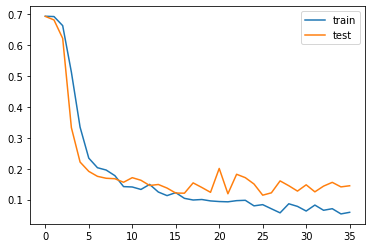

In [105]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

loading the best model

In [106]:
from keras.models import load_model
model=load_model('best_model.hdf5')

OSError: Unable to open file (unable to open file: name = 'best_model.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Define the function that predicts text for the given audio:

In [107]:
def predict(audio):
    prob = model.predict(audio.reshape(1,8000,1))
    index = np.argmax(prob[0])
    return classes[index]

Prediction time! Make predictions on the validation data

In [109]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: left
Text: left


 Record your own voice commands and test it on the model:

In [111]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

ModuleNotFoundError: No module named 'sounddevice'

Let us now read the saved voice command and convert it to text

In [ ]:

filepath='C:/Users/rafoo/Desktop/Alexa/source/'

#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'left1.wav', sr = 8000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

predict(samples)